In [5]:
import os
import pandas as pd
import numpy as np
import PIL
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from keras.models import load_model,save_model
from keras.callbacks import ModelCheckpoint
from matplotlib.patches import Rectangle
import os
from scipy.misc import imsave

import keras

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.preprocessing import image
from keras.applications import xception
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Input, Lambda
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers import BatchNormalization
from math import sqrt
from keras.callbacks import History 
import gc
from numpy.random import randint, choice
import numpy.random as rng

import keras.backend as K

In [6]:
from keras.preprocessing import image

def read_img(filepath, size):
    img = image.load_img((filepath), target_size=size)
    img = image.img_to_array(img,data_format='channels_last')
    return img

In [7]:
input_dim = (45,45,3)
imgSize=(45,45)

basePath = "/home/rsk/Documents/Projects/GenericModels/SiameseNetworks/Dataset"
trainPath = os.path.join(basePath,'Train')
testPath = os.path.join(basePath,'Test')

In [13]:
folderList = os.listdir(trainPath)

### Generator Method

In [57]:
posSampleProb = np.repeat(1/30.0,30)
posSampleList = np.repeat(1.0,30)

In [54]:
posSampleProb

array([0.03333333, 0.03333333, 0.03333333, 0.03333333, 0.03333333,
       0.03333333, 0.03333333, 0.03333333, 0.03333333, 0.03333333,
       0.03333333, 0.03333333, 0.03333333, 0.03333333, 0.03333333,
       0.03333333, 0.03333333, 0.03333333, 0.03333333, 0.03333333,
       0.03333333, 0.03333333, 0.03333333, 0.03333333, 0.03333333,
       0.03333333, 0.03333333, 0.03333333, 0.03333333, 0.03333333])

In [51]:
negSampleNames=[]

for x in range(len(folderList)-1):
    for y in range(x+1,len(folderList)):
        negSampleNames.append(str(x)+'_'+str(y))

negSampleProb = np.repeat(1.0/len(negSampleNames),len(negSampleNames))
negSampleList = np.repeat(1.0,len(negSampleNames))

In [19]:
negSampleNames

['0_1',
 '0_2',
 '0_3',
 '0_4',
 '0_5',
 '0_6',
 '0_7',
 '0_8',
 '0_9',
 '0_10',
 '0_11',
 '0_12',
 '0_13',
 '0_14',
 '0_15',
 '0_16',
 '0_17',
 '0_18',
 '0_19',
 '0_20',
 '0_21',
 '0_22',
 '0_23',
 '0_24',
 '0_25',
 '0_26',
 '0_27',
 '0_28',
 '0_29',
 '1_2',
 '1_3',
 '1_4',
 '1_5',
 '1_6',
 '1_7',
 '1_8',
 '1_9',
 '1_10',
 '1_11',
 '1_12',
 '1_13',
 '1_14',
 '1_15',
 '1_16',
 '1_17',
 '1_18',
 '1_19',
 '1_20',
 '1_21',
 '1_22',
 '1_23',
 '1_24',
 '1_25',
 '1_26',
 '1_27',
 '1_28',
 '1_29',
 '2_3',
 '2_4',
 '2_5',
 '2_6',
 '2_7',
 '2_8',
 '2_9',
 '2_10',
 '2_11',
 '2_12',
 '2_13',
 '2_14',
 '2_15',
 '2_16',
 '2_17',
 '2_18',
 '2_19',
 '2_20',
 '2_21',
 '2_22',
 '2_23',
 '2_24',
 '2_25',
 '2_26',
 '2_27',
 '2_28',
 '2_29',
 '3_4',
 '3_5',
 '3_6',
 '3_7',
 '3_8',
 '3_9',
 '3_10',
 '3_11',
 '3_12',
 '3_13',
 '3_14',
 '3_15',
 '3_16',
 '3_17',
 '3_18',
 '3_19',
 '3_20',
 '3_21',
 '3_22',
 '3_23',
 '3_24',
 '3_25',
 '3_26',
 '3_27',
 '3_28',
 '3_29',
 '4_5',
 '4_6',
 '4_7',
 '4_8',
 '4_9',


In [22]:
class Generator:
    
    def __init__(self,numCharacters):
        
        self.posSampleProb = np.repeat(1/30.0,30)
        self.posSampleList = np.repeat(1.0,30)
        
        self.negSampleNames=[]

        for x in range(len(folderList)-1):
            for y in range(x+1,len(folderList)):
                self.negSampleNames.append(str(x)+'_'+str(y))

        self.negSampleProb = np.repeat(1.0/len(self.negSampleNames),len(self.negSampleNames))
        self.negSampleList = np.repeat(1.0,len(self.negSampleNames))
        
    
    
    def updateProb(self):
    
        newPosProb = np.zeros(self.posSampleProb.shape)

        for i in range(len(self.posSampleProb)):
            newPosProb[i] =  sum(self.posSampleList) - self.posSampleList[i]
            
#             newPosProb[i] = max(0.0,1.0/len(self.posSampleProb) - newPosProb[i])
        newPosProb = newPosProb/sum(newPosProb)
        self.posSampleProb = newPosProb


        newNegProb = np.zeros(self.negSampleProb.shape)

        for i in range(len(self.negSampleProb)):
            newNegProb[i] = sum(self.negSampleList) - self.negSampleList[i]
#             newNegProb[i] = max(0.0,1.0/len(self.negSampleProb) - newNegProb[i])
        newNegProb = newNegProb/sum(newNegProb)
        self.negSampleProb = newNegProb
        
    
    def getBatch(self,batchSize,s):
    

        posSamples = batchSize/2 + batchSize%2
        negSamples = batchSize - posSamples

#         print(self.posSampleProb)
#         print(self.negSampleProb)
    
        #positiveSamples 
        posPairList = []
        posFolder = choice(len(folderList),p=self.posSampleProb)

        imgList = os.listdir(os.path.join(trainPath,folderList[posFolder]))

        for x in range(len(imgList)-1):
            for y in range(x+1, len(imgList)):

                img1 = read_img(os.path.join(trainPath,folderList[posFolder],imgList[x]) , imgSize)
                img2 = read_img(os.path.join(trainPath,folderList[posFolder],imgList[y]) , imgSize)


                posPairList.append(((img1,img2),1))

                if len(posPairList) == posSamples:
                    break

        self.posSampleList[posFolder] += posSamples


        #negativeSamples
        negPairList = []



        for i in range(negSamples):
            folderNo = choice(len(self.negSampleNames),p=self.negSampleProb)
            negFolder = self.negSampleNames[folderNo]

            x,y = int(negFolder.split("_")[0]),int(negFolder.split("_")[0])

            imgList1 = os.listdir(os.path.join(trainPath,folderList[x]))
            imgList2 = os.listdir(os.path.join(trainPath,folderList[y]))

            img1 = read_img(os.path.join(trainPath,folderList[x],imgList1[choice(len(imgList1))]) , imgSize)
            img2 = read_img(os.path.join(trainPath,folderList[y],imgList2[choice(len(imgList2))]) , imgSize)

            negPairList.append(((img1,img2),0))

            self.negSampleList[folderNo]+=1

            if len(negPairList) == negSamples:
                break

        self.updateProb()

        pairList = posPairList + negPairList


        inputAimgs = np.array([x[0][0] for x in pairList])
        inputBimgs = np.array([x[0][1] for x in pairList])
        target = np.array([x[1] for x in pairList])        

        return( [inputAimgs,inputBimgs], target)
    
    
    def generate(self, batch_size, s="train"):
        """a generator for batches, so model.fit_generator can be used. """
        while True:
            pairs, targets = self.getBatch(batch_size,s)
            yield (pairs, targets) 
    
    


In [26]:
y

17

In [5]:
21/2 + 21%2

11

In [9]:
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

def compute_accuracy(predictions, labels):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return labels[predictions.ravel() < 0.5].mean()

def W_init(shape,name=None):
    """Initialize weights as in paper"""
    values = rng.normal(loc=0,scale=1e-2,size=shape)
    return K.variable(values,name=name)
#//TODO: figure out how to initialize layer biases in keras.

def b_init(shape,name=None):
    """Initialize bias as in paper"""
    values=rng.normal(loc=0.5,scale=1e-2,size=shape)
    return K.variable(values,name=name)

In [10]:
baseModel = Sequential()
baseModel.add(BatchNormalization(input_shape = input_dim))
baseModel.add(Conv2D(64, (7,7),activation='relu', data_format='channels_last',kernel_initializer=W_init))
baseModel.add(MaxPooling2D())

baseModel.add(Dropout(0.3))
baseModel.add(Conv2D(128, (5,5),activation='relu',kernel_initializer=W_init, bias_initializer=b_init))
baseModel.add(Dropout(0.3))
baseModel.add(Conv2D(256, (3,3),activation='relu',kernel_initializer=W_init, bias_initializer=b_init))
baseModel.add(Flatten())
baseModel.add(Dense(1028, activation='relu'))
# baseModel.add(Dense(32, activation='relu'))


inputA = Input(shape = input_dim)
inputB = Input(shape = input_dim)

outputA = baseModel(inputA)
outputB = baseModel(inputB)

#Extracting data
# inputAimgs = np.array([x[0][0] for x in superList])
# inputBimgs = np.array([x[0][1] for x in superList])
# target = np.array([x[1] for x in superList])

### Model 1


In [113]:
L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
L1_distance = L1_layer([outputA, outputB])
prediction = Dense(1,activation='sigmoid')(L1_distance)
siamese_net = Model(inputs=[inputA,inputB],outputs=prediction)

siamese_net.compile(loss="binary_crossentropy",optimizer='adadelta',metrics=['accuracy'])

In [ ]:
siamese_net.fit([inputAimgs,inputBimgs], target, batch_size = 20,epochs = 10 )

### Model 2

In [11]:
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([outputA,outputB])

model = Model(input=[inputA, inputB], output=distance)

model.compile(loss=contrastive_loss,optimizer='adadelta')


/home/rsk/.local/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("la..., inputs=[<tf.Tenso...)`
  This is separate from the ipykernel package so we can avoid doing imports until


In [23]:
gen = Generator(30)

In [24]:
model.fit_generator(gen.generate(25,'s'),epochs=5,steps_per_epoch=5)

Epoch 1/5
5/5 [==============================] - 11s 2s/step - loss: 8.0631
Epoch 2/5
5/5 [==============================] - 2s 330ms/step - loss: 0.7664
Epoch 3/5
5/5 [==============================] - 2s 330ms/step - loss: 0.2025
Epoch 4/5
5/5 [==============================] - 2s 329ms/step - loss: 0.1652
Epoch 5/5
5/5 [==============================] - 2s 315ms/step - loss: 0.1480


In [165]:
model.fit([inputAimgs,inputBimgs], target, batch_size = 30,epochs = 10 )

Epoch 1/10
21390/21390 [==============================] - 112s 5ms/step - loss: 0.1940
Epoch 2/10
21390/21390 [==============================] - 108s 5ms/step - loss: 0.1344
Epoch 3/10
21390/21390 [==============================] - 108s 5ms/step - loss: 0.1115
Epoch 4/10
21390/21390 [==============================] - 108s 5ms/step - loss: 0.1018
Epoch 5/10
21390/21390 [==============================] - 110s 5ms/step - loss: 0.0942
Epoch 6/10
21390/21390 [==============================] - 108s 5ms/step - loss: 0.0893
Epoch 7/10
21390/21390 [==============================] - 108s 5ms/step - loss: 0.0855
Epoch 8/10
21390/21390 [==============================] - 108s 5ms/step - loss: 0.0823
Epoch 9/10
21390/21390 [==============================] - 108s 5ms/step - loss: 0.0795
Epoch 10/10
21390/21390 [==============================] - 107s 5ms/step - loss: 0.0764


## Testing

In [168]:
def predictBest(img,label,imgSupport,model):
    
    bestPred=0.0
    bestLabel=''
    bestImg = 0
    
#     plt.subplot(211)
#     plt.imshow(img)
    
    for i in range(len(imgSupport)):
        pred = model.predict([img.reshape(1,imgSize[0],imgSize[1],3), imgSupport[i][0].reshape(1,imgSize[0],imgSize[1],3)])
#         print("label : {}  Pred : {}".format(imgSupport[i][1], pred))
        
        if pred>bestPred:
            bestPred = pred
            bestLabel = imgSupport[i][1]
            bestImg = imgSupport[i][0]
    
#     plt.subplot(212)
#     plt.imshow(bestImg)
    return(bestLabel)
    

def getSupportImgs(path):
    
    supportImg=[]
    
    os.chdir(path)
    folderList = os.listdir("./")
    
    for folder in folderList:
        os.chdir(os.path.join(path,folder))
        imgList = os.listdir("./")
        
        img = read_img(os.path.join(path,folder,choice(imgList)), imgSize)
        supportImg.append([img,folder])
        
    return(supportImg)
        

def predictBestFolder(img,label,trainPath,model,numImages = 5,printList = False,testClasses = 30):
    
    predList = []
    
    folderList = sorted(os.listdir(trainPath))[:testClasses]
    
    for folder in folderList:
        
        imgList = choice(os.listdir(os.path.join(trainPath,folder)), numImages, replace = False )
        folderPreds = []
        
        for i in range(numImages):
            folderImg = read_img(os.path.join(trainPath,folder,imgList[i]), imgSize )
            pred = model.predict([img.reshape(1,imgSize[0],imgSize[1],3), folderImg.reshape(1,imgSize[0],imgSize[1],3)])
            folderPreds.append(pred)
        
        predList.append([folder, np.mean(folderPreds)])
    
    predList = sorted(predList, key = lambda x:x[1])
    
    if printList == True:
        print(predList)
        
    return(predList[0])

def searchList(word):
    
    searchList = []
    for i in range(len(labelList)):
        if word in labelList[i]:
            searchList.append(labelList[i])
    
    return(searchList)


#### Accuracy on test data

In [166]:
## 30-way testing

os.chdir(testPath)
folderList = os.listdir("./")

correctPred = 0
testImageCount = 0

for folder in folderList:
    os.chdir(os.path.join(testPath,folder))
    imgList = os.listdir("./")
    
    for img in imgList:
        imgName = img
        testImageCount+=1
        supportImg = getSupportImgs(trainPath)
        
        img = read_img(os.path.join(testPath,folder,img), imgSize)
        bestLabel = predictBestFolder(img,folder,trainPath,model,15)[0]
        
        if bestLabel == folder:
            correctPred+=1
        acc = round(correctPred/float(testImageCount),3)
        print("Img : {} True Label : {}  Predicted Label : {} Accuracy : {}".format(imgName,folder,bestLabel,acc))
        
accuracy = correctPred/float(testImageCount)
print("Accuracy : {}".format(accuracy))

Img : 0047_20.png True Label : character21  Predicted Label : character21 Accuracy : 1.0
Img : 0047_16.png True Label : character21  Predicted Label : character21 Accuracy : 1.0
Img : 0047_17.png True Label : character21  Predicted Label : character21 Accuracy : 1.0
Img : 0047_18.png True Label : character21  Predicted Label : character21 Accuracy : 1.0
Img : 0047_19.png True Label : character21  Predicted Label : character21 Accuracy : 1.0
Img : 0049_18.png True Label : character23  Predicted Label : character23 Accuracy : 1.0
Img : 0049_17.png True Label : character23  Predicted Label : character23 Accuracy : 1.0
Img : 0049_20.png True Label : character23  Predicted Label : character27 Accuracy : 0.875
Img : 0049_16.png True Label : character23  Predicted Label : character23 Accuracy : 0.889
Img : 0049_19.png True Label : character23  Predicted Label : character23 Accuracy : 0.9
Img : 0032_18.png True Label : character06  Predicted Label : character20 Accuracy : 0.818
Img : 0032_20.p

Img : 0043_17.png True Label : character17  Predicted Label : character17 Accuracy : 0.717
Img : 0043_19.png True Label : character17  Predicted Label : character17 Accuracy : 0.72
Img : 0043_20.png True Label : character17  Predicted Label : character17 Accuracy : 0.723
Img : 0043_16.png True Label : character17  Predicted Label : character17 Accuracy : 0.726
Img : 0050_18.png True Label : character24  Predicted Label : character22 Accuracy : 0.719
Img : 0050_17.png True Label : character24  Predicted Label : character04 Accuracy : 0.711
Img : 0050_16.png True Label : character24  Predicted Label : character28 Accuracy : 0.704
Img : 0050_19.png True Label : character24  Predicted Label : character24 Accuracy : 0.707
Img : 0050_20.png True Label : character24  Predicted Label : character04 Accuracy : 0.7
Img : 0033_20.png True Label : character07  Predicted Label : character07 Accuracy : 0.703
Img : 0033_19.png True Label : character07  Predicted Label : character07 Accuracy : 0.706
Im

In [167]:
accuracy = correctPred/float(testImageCount)
print("Accuracy : {}".format(accuracy))

Accuracy : 0.74


In [169]:
# 20-way testing



os.chdir(testPath)
folderList = sorted(os.listdir("./"))[:20]

correctPred = 0
testImageCount = 0

for folder in folderList:
    os.chdir(os.path.join(testPath,folder))
    imgList = os.listdir("./")
    
    for img in imgList:
        imgName = img
        testImageCount+=1
        
        img = read_img(os.path.join(testPath,folder,img), imgSize)
        bestLabel = predictBestFolder(img,folder,trainPath,model,15,testClasses=20)[0]
        
        if bestLabel == folder:
            correctPred+=1
        acc = round(correctPred/float(testImageCount),3)
        print("Img : {} True Label : {}  Predicted Label : {} Accuracy : {}".format(imgName,folder,bestLabel,acc))
        
accuracy = correctPred/float(testImageCount)
print("Accuracy : {}".format(accuracy))



Img : 0027_20.png True Label : character01  Predicted Label : character01 Accuracy : 1.0
Img : 0027_16.png True Label : character01  Predicted Label : character01 Accuracy : 1.0
Img : 0027_19.png True Label : character01  Predicted Label : character01 Accuracy : 1.0
Img : 0027_18.png True Label : character01  Predicted Label : character01 Accuracy : 1.0
Img : 0027_17.png True Label : character01  Predicted Label : character01 Accuracy : 1.0
Img : 0028_20.png True Label : character02  Predicted Label : character02 Accuracy : 1.0
Img : 0028_17.png True Label : character02  Predicted Label : character02 Accuracy : 1.0
Img : 0028_18.png True Label : character02  Predicted Label : character02 Accuracy : 1.0
Img : 0028_16.png True Label : character02  Predicted Label : character02 Accuracy : 1.0
Img : 0028_19.png True Label : character02  Predicted Label : character02 Accuracy : 1.0
Img : 0029_19.png True Label : character03  Predicted Label : character03 Accuracy : 1.0
Img : 0029_16.png Tru

Img : 0045_17.png True Label : character19  Predicted Label : character19 Accuracy : 0.793
Img : 0045_20.png True Label : character19  Predicted Label : character19 Accuracy : 0.796
Img : 0045_16.png True Label : character19  Predicted Label : character19 Accuracy : 0.798
Img : 0045_19.png True Label : character19  Predicted Label : character19 Accuracy : 0.8
Img : 0046_18.png True Label : character20  Predicted Label : character20 Accuracy : 0.802
Img : 0046_17.png True Label : character20  Predicted Label : character20 Accuracy : 0.804
Img : 0046_20.png True Label : character20  Predicted Label : character20 Accuracy : 0.806
Img : 0046_16.png True Label : character20  Predicted Label : character20 Accuracy : 0.808
Img : 0046_19.png True Label : character20  Predicted Label : character20 Accuracy : 0.81
Accuracy : 0.81


In [171]:
save_model(model,'./bestModel_0.81.hdf5')

#### Accuracy on Train Data

In [128]:
os.chdir(trainPath)
folderList = os.listdir("./")

correctPred = 0
testImageCount = 0

for folder in folderList:
    os.chdir(os.path.join(trainPath,folder))
    imgList = os.listdir("./")
    
    for img in imgList:
        imgName = img
        testImageCount+=1
        supportImg = getSupportImgs(trainPath)
        
        img = read_img(os.path.join(trainPath,folder,img), imgSize)
        bestLabel = predictBest(img,folder,supportImg,model)
        
        if bestLabel == folder:
            correctPred+=1
        print("Img : {} True Label : {}  Predicted Label : {}".format(imgName,folder,bestLabel))
        
accuracy = correctPred/float(testImageCount)
print("Accuracy : {}".format(accuracy))

Img : 0871_10.png True Label : character21  Predicted Label : character09
Img : 0871_01.png True Label : character21  Predicted Label : character09
Img : 0871_04.png True Label : character21  Predicted Label : character09
Img : 0871_07.png True Label : character21  Predicted Label : character09
Img : 0871_03.png True Label : character21  Predicted Label : character09
Img : 0871_13.png True Label : character21  Predicted Label : character09
Img : 0871_06.png True Label : character21  Predicted Label : character09
Img : 0871_05.png True Label : character21  Predicted Label : character09
Img : 0871_15.png True Label : character21  Predicted Label : character09
Img : 0871_02.png True Label : character21  Predicted Label : character09
Img : 0871_09.png True Label : character21  Predicted Label : character09
Img : 0871_11.png True Label : character21  Predicted Label : character09
Img : 0871_08.png True Label : character21  Predicted Label : character09
Img : 0871_14.png True Label : charact

Img : 0854_14.png True Label : character04  Predicted Label : character11
Img : 0854_05.png True Label : character04  Predicted Label : character11
Img : 0854_15.png True Label : character04  Predicted Label : character11
Img : 0854_12.png True Label : character04  Predicted Label : character11
Img : 0854_06.png True Label : character04  Predicted Label : character11
Img : 0854_08.png True Label : character04  Predicted Label : character11
Img : 0854_03.png True Label : character04  Predicted Label : character11
Img : 0854_04.png True Label : character04  Predicted Label : character11
Img : 0862_12.png True Label : character12  Predicted Label : character19
Img : 0862_07.png True Label : character12  Predicted Label : character19
Img : 0862_02.png True Label : character12  Predicted Label : character19
Img : 0862_04.png True Label : character12  Predicted Label : character19
Img : 0862_05.png True Label : character12  Predicted Label : character19
Img : 0862_09.png True Label : charact

Img : 0877_09.png True Label : character27  Predicted Label : character19
Img : 0877_14.png True Label : character27  Predicted Label : character19
Img : 0865_10.png True Label : character15  Predicted Label : character14
Img : 0865_12.png True Label : character15  Predicted Label : character11
Img : 0865_04.png True Label : character15  Predicted Label : character11
Img : 0865_11.png True Label : character15  Predicted Label : character11
Img : 0865_08.png True Label : character15  Predicted Label : character11
Img : 0865_09.png True Label : character15  Predicted Label : character14
Img : 0865_15.png True Label : character15  Predicted Label : character11
Img : 0865_03.png True Label : character15  Predicted Label : character11
Img : 0865_05.png True Label : character15  Predicted Label : character11
Img : 0865_07.png True Label : character15  Predicted Label : character11
Img : 0865_02.png True Label : character15  Predicted Label : character11
Img : 0865_06.png True Label : charact

Img : 0861_13.png True Label : character11  Predicted Label : character19
Img : 0861_02.png True Label : character11  Predicted Label : character19
Img : 0861_10.png True Label : character11  Predicted Label : character19
Img : 0861_05.png True Label : character11  Predicted Label : character19
Img : 0861_11.png True Label : character11  Predicted Label : character19
Img : 0861_09.png True Label : character11  Predicted Label : character19
Img : 0861_04.png True Label : character11  Predicted Label : character19
Img : 0861_08.png True Label : character11  Predicted Label : character19
Img : 0861_15.png True Label : character11  Predicted Label : character19
Img : 0861_06.png True Label : character11  Predicted Label : character19
Img : 0851_11.png True Label : character01  Predicted Label : character11
Img : 0851_12.png True Label : character01  Predicted Label : character11
Img : 0851_05.png True Label : character01  Predicted Label : character11
Img : 0851_06.png True Label : charact

Img : 0855_15.png True Label : character05  Predicted Label : character19
Img : 0855_07.png True Label : character05  Predicted Label : character19
Img : 0855_09.png True Label : character05  Predicted Label : character19
Img : 0855_14.png True Label : character05  Predicted Label : character19
Accuracy : 0.0


In [122]:
accuracy = correctPred/float(testImageCount)
print("Accuracy : {}".format(accuracy))

Accuracy : 0.377777777778


### Accessory Functions 
##### To evaluate the predictions

In [119]:
def getImage(folder,imgNo,train=True):
    
    if train==True:
        image = sorted(os.listdir(os.path.join(trainPath,folder)))[imgNo]
        image = read_img(os.path.join(trainPath,folder,image), imgSize)
    else:
        image = sorted(os.listdir(os.path.join(testPath,folder)))[imgNo]
        image = read_img(os.path.join(testPath,folder,image), imgSize)
        
    return(image)
        
    
a = getImage('character03',4,train = False)

In [120]:
predictBestFolder(a,'xxxx',trainPath,model,15,printList=True)

[['character18', 0.47063953], ['character03', 0.5668649], ['character06', 0.7414245], ['character04', 0.90950096], ['character24', 1.0128773], ['character30', 1.0532554], ['character26', 1.0919914], ['character15', 1.1090348], ['character22', 1.1398655], ['character08', 1.1790216], ['character19', 1.1845927], ['character27', 1.1921993], ['character17', 1.2045933], ['character20', 1.4039037], ['character29', 1.4283993], ['character07', 1.4514846], ['character02', 1.635681], ['character01', 1.6868922], ['character28', 1.7018459], ['character12', 1.713475], ['character14', 1.7223102], ['character05', 1.7527518], ['character13', 1.7751232], ['character10', 1.793034], ['character16', 1.8568423], ['character11', 1.8821567], ['character09', 1.9020066], ['character23', 1.9939858], ['character25', 2.1224973], ['character21', 2.1603959]]


['character18', 0.47063953]

In [58]:
def checkPred(folder1,img1,folder2,img2,train1=True,train2=True):
    
    if train1 == True:
        image1 = sorted(os.listdir(os.path.join(trainPath,folder1)))[img1]
        image1 = read_img(os.path.join(trainPath,folder1,image1), imgSize)
    else:
        image1 = sorted(os.listdir(os.path.join(testPath,folder1)))[img1]
        image1 = read_img(os.path.join(testPath,folder1,image1), imgSize)
        
    if train2 == True:
        image2 = sorted(os.listdir(os.path.join(trainPath,folder2)))[img2]
        image2 = read_img(os.path.join(trainPath,folder2,image2), imgSize)
    else:
        image2 = sorted(os.listdir(os.path.join(testPath,folder2)))[img2]
        print(image2)
        image2 = read_img(os.path.join(testPath,folder2,image2), imgSize)
        
    
    pred = model.predict([image1.reshape(1,45,45,3), image2.reshape(1,imgSize[0],imgSize[1],3)])
    
    plt.subplot(211)
    plt.imshow(image1)
    
    plt.subplot(212)
    plt.imshow(image2)
    
    print(pred)
        
    

0028_18.png
[[0.60623467]]


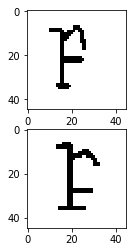

In [82]:
checkPred('character02',5,'character02',2,train2= False)